<a href="https://colab.research.google.com/github/s-c-soma/Deeplearning-CMPE-258/blob/main/Assignment_3/Assignment_3_Part_C_3_Tensorflow(keras_linear_modules).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Layer Neural Network (with relu nonlinearity) Using Tensorflow(keras  linear modules)
- high level primitives and build neural network(using Model subclassing, not functional api or sequential api).

# Implementation Details and Discussion

* Here, I have generated the 3d input and 2d output data first.
* Then I have built a 3 layer neural network with ReLU non linearity using Tensorflow Auto Differenciation
* Used high level primitives and built neural network(using Model subclassing, not functional api or sequential api).
* Here the output has 2 neurons

## Steps: 
I have listed down the the formula and steps I have followed in each section:
- Initialized the parameters for a three-layer network 
- Used Tensorflow Keras
- Defined the 3layer architechture 
- Then training including fw and back propagation
- Finally updated the parameters.
- Validation is also done
- 1.4304066896438599

## Equation of Multi Layer:
$$ Z^{[l]} = W^{[l]}A^{[l-1]} + b^{[l]} $$

$$ A^{[l]} = g^{[l]}(Z^{[l]}) $$

Where $l$ is the `lth` layer.

## ExtraCredit:
* At the bottom I have plotted the data in 3d space. 
* To plot 3 dimensional data, I have reduced x into 2-d using TSNE

# Check if GPU/TPU available

In [ ]:
!nvidia-smi

Wed Mar 17 10:44:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    35W / 250W |    417MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Colab environment

In [ ]:
!python --version

Python 3.7.10


In [ ]:
!pip list | grep tensor

tensorboard                   2.4.1         
tensorboard-plugin-wit        1.8.0         
tensorflow                    2.4.1         
tensorflow-datasets           4.0.1         
tensorflow-estimator          2.4.0         
tensorflow-gcs-config         2.4.0         
tensorflow-hub                0.11.0        
tensorflow-metadata           0.28.0        
tensorflow-probability        0.12.1        


In [ ]:
!pip list | grep torch

torch                         1.8.0+cu101   
torchsummary                  1.5.1         
torchtext                     0.9.0         
torchvision                   0.9.0+cu101   


# Library

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Layer

import matplotlib.pyplot as plt
from typing import Callable
from sklearn.manifold import TSNE
import pdb

# Generating Data: 3D Input :: 2D Output

In [ ]:
# Generating data of 3 dim input and 2 dim output
n, d = 500, 3
x = tf.random.uniform(minval=-1, maxval=1, shape = (n, d))
x2 = tf.cast(x**2, tf.float32)
weights_true = tf.cast(tf.constant([[5,1,5],[1,2,1]]), tf.float32)
bias_true = tf.cast(tf.constant([1,2]), tf.float32)
y_true = tf.matmul(x2, weights_true, transpose_b=True) + tf.matmul(x,weights_true,transpose_b=True) + bias_true

print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: (500, 3), weights: (2, 3), bias: (2,), y: (500, 2)


# Building Multi Layer NN using GradientTape: 3 Layer


## Linear Layer

In [ ]:

class Linear(Layer):
  """y = w.x + b"""

  def __init__(self, units=32):
      super(Linear, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

## Dropout Layer

In [ ]:
class Dropout(Layer):
  
  def __init__(self, rate):
    super(Dropout, self).__init__()
    self.rate = rate

  def call(self, inputs, training=None):
    if training:
      return tf.nn.dropout(inputs, rate=self.rate)
    return inputs

## Model Class Architecture

In [ ]:
#custom model class
class MLP(Layer):
    """Simple stack of Linear layers."""

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = Linear(22)
        self.dropout = Dropout(0.5)
        self.linear_2 = Linear(12)
        self.dropout = Dropout(0.5)
        self.linear_3 = Linear(2)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        return self.linear_3(x)

# Model Training and Validation 

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

dataset = tf.data.Dataset.from_tensor_slices((x, y_true))
dataset = dataset.shuffle(buffer_size=1).batch(30)

epochs = 500
mlp = MLP()
# Iterate over epochs.
for epoch in range(epochs):

    # Iterate over the batches of the dataset.
    for step, (x_batch, y_batch) in enumerate(dataset):
        with tf.GradientTape() as tape:
            # Forward Pass
            y_pred_batch = mlp(x_batch)
            # Compute loss
            loss = mse_loss_fn(y_batch, y_pred_batch)
            loss += sum(mlp.losses)  # Add regularization loss

        grads = tape.gradient(loss, mlp.trainable_weights) # Use autograd
        optimizer.apply_gradients(zip(grads, mlp.trainable_weights)) # Update learnable parameter

        loss_metric(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch}, loss {loss_metric.result()}')

Epoch 0, loss 0.8411017656326294
Epoch 100, loss 0.818614661693573
Epoch 200, loss 0.8005959987640381
Epoch 300, loss 0.7827211618423462
Epoch 400, loss 0.7644556164741516


# Visualization: Training Data and Prediction

## Plot:: Generated Data

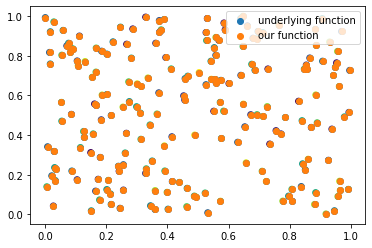

In [ ]:
# # # Make non-linear data, using 3 dimensional input data and 2 output neurons
n = 200
d1 = 3
d2 = 2
input_dim = 3
output_dim = 2
learning_rate = 0.01
# This is our weight matrix
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))
x = tf.Variable(tf.random.uniform(shape=(n, d1)))
y = tf.Variable(tf.random.uniform(shape=(n, d2)))

y_true = tf.matmul(tf.pow(x,2), w) + tf.matmul(x, w) + b
plt.scatter(x[:, 0], x[:, 1], c=y[:, 0])
plt.scatter(x[:, 0], x[:, 1], label='underlying function')
if y_true is not None:
  plt.scatter(x[:, 0], x[:, 1], label='our function')
  plt.legend()

## ExtraCredit: t-SNE 3D Plot

In [ ]:
def plot_intereactive_3d(x, y, y_pred=None):
  import plotly.graph_objects as go

  fig = go.Figure()
  fig.add_trace(go.Scatter3d(x = x[:,0],
                    y = x[:,1],
                    z = y.reshape([-1]),
                    opacity=0.5, mode='markers', name='Underlying Function'
                    ))
 
  if y_pred is not None:
    fig.add_trace(go.Scatter3d(x = x[:,0],
                   y = x[:,1],
                   z = y_pred.reshape([-1]),
                   opacity=0.5, mode='markers', name='Predicted Function'
                  ))
    
  fig.update_layout(scene = dict(
                    xaxis_title='X1',
                    yaxis_title='X2',
                    zaxis_title='Y'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
  fig.show()

In [ ]:
from sklearn.manifold import TSNE
X_reduced = TSNE(n_components=2).fit_transform(x)
y_true_reduced = TSNE(n_components=1).fit_transform(y_true)
y_pred_reduced = TSNE(n_components=1).fit_transform(mlp(x))
print(f'X_reduced: {X_reduced.shape}, y_true_reduced: {y_true_reduced.shape}, y_pred_reduced: {y_pred_reduced.shape}')
plot_intereactive_3d(X_reduced,y_true_reduced,y_pred_reduced)

X_reduced: (500, 2), y_true_reduced: (500, 1), y_pred_reduced: (500, 1)
